In [5]:
import numpy as np                               
import pandas as pd      
pd.options.display.max_columns =100
import matplotlib.pyplot as plt                  
import seaborn as sns       
%matplotlib inline
import warnings                                  
warnings.filterwarnings('ignore')
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_two_lines(df, target, new_col): 
    plt.figure(figsize=(15, 7))
    plt.plot(df[target])
    plt.plot(df[new_col])
    plt.title(str(new_col) + ' + benzene')
    plt.grid(True)
    plt.show()

In [6]:
# считываем данные

wek = pd.read_csv('weekly_data.csv')
wek['date'] = pd.DatetimeIndex(wek['Unnamed: 0'])
wek['mnth_yr'] = wek['date'].apply(lambda x: x.strftime('%m/%Y')) 
del wek['Unnamed: 0']
del wek['feature_target']

currency = pd.read_csv('cur.csv')
currency['date'] = pd.DatetimeIndex(currency['week'])
del currency['Unnamed: 0']
del currency['week']

merged = wek.merge(currency, on='date')
merged.to_csv('merged.csv')

In [7]:
# Создадим несколько взаимодействий Benzen & OIL
merged['Benzen-OILx10'] = merged['Benzene Spot CIF ARA Current Month'] - merged['OIL_mean'] * 10
merged['Benzen/OILx10'] = merged['Benzene Spot CIF ARA Current Month'] / merged['OIL_mean'] * 10
merged['Benzen%OILx10'] = merged['Benzene Spot CIF ARA Current Month'] % merged['OIL_mean'] * 10

In [8]:
# Выделим важные переменные
merged = merged[['Benzene Spot CIF ARA Current Month', 
                'date',
                'Propylene Spot CFR Asia SE 2-6 Weeks',
                'Ethylene Spot CIF NWE 0-6 Weeks',
                'Methyl Acrylate Spot FD NWE 2-4- Weeks',
                'Toluene Spot Close CIF Med 4-6 Weeks',
                'Orthoxylene Spot FOB Rotterdam 4 Weeks',
                'Paraxylene Spot FOB Rotterdam 4 Weeks',
                'Naphtha Cargoes Spot FOB Med 4 Weeks',
                'USDRUB_mean',
                'USDRUB_std',
                'EURUSD_mean',
                'EURUSD_std',
                'USDCNY_mean',
                'USDCNY_std',
                'OIL_mean',
                'OIL_std',
                'Benzen-OILx10',
                'Benzen/OILx10',
                'Benzen%OILx10' ]]

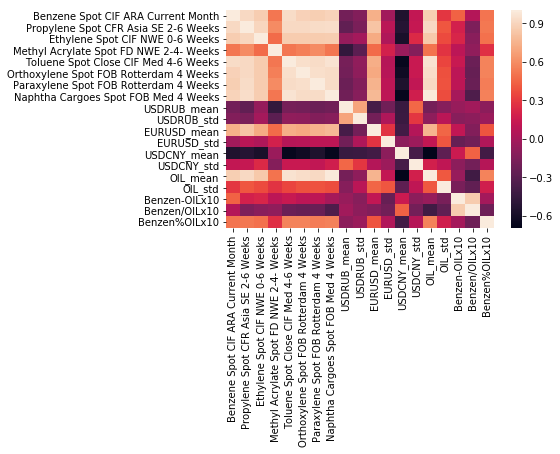

In [9]:
sns.heatmap(merged.corr())

In [10]:
# Создадим функцию по генерации фичей

diff = pd.DataFrame()

def get_data(df):
    for i in df.columns:
        
        # MA
        diff[i+str('_rolling_mean_4')] = df[i].rolling(window=4).mean()
        diff[i+str('_rolling_mean_10')] = df[i].rolling(window=10).mean()
        diff[i+str('_rolling_signal_10')] = np.where(diff[i+str('_rolling_mean_4')] > diff[i+str('_rolling_mean_10')] , 1, 0) 

        # EMA
        diff[i+str('_ema_5')] = df[i].ewm(span=5, adjust=False).mean()
        diff[i+str('_ema_10')] = df[i].ewm(span=10, adjust=False).mean()

        # Пересечения EMA и таргета
        #trading_positions_raw 
        diff[i+str('_ema_cross_5')] = df[i] - diff[i+str('_ema_5')]
        diff[i+str('_ema_cross_10')] = df[i] - diff[i+str('_ema_10')]

        # разница логарифмов текущего и предыдущего значения
        #diff[i+str('_np_log_diff')] = np.log(df[i]).diff()

        # процентная разница между текущим и предыдущим значением
        #diff[i+str('_pct_change1')] = df[i].pct_change(1)
        
    return diff

In [11]:
# Применим функцию
diff = get_data(merged.drop('date', axis=1))
diff['date'] = merged['date']

df = merged.merge(diff, on='date')


In [12]:
#  Проверим нули
df.isna().sum().sort_values(ascending=False).head()

Methyl Acrylate Spot FD NWE 2-4- Weeks_rolling_mean_10    241
Propylene Spot CFR Asia SE 2-6 Weeks_rolling_mean_10      205
Naphtha Cargoes Spot FOB Med 4 Weeks_rolling_mean_10      197
Toluene Spot Close CIF Med 4-6 Weeks_rolling_mean_10      192
Orthoxylene Spot FOB Rotterdam 4 Weeks_rolling_mean_10    192
dtype: int64

In [13]:
# Заполним пропуски и удалим то, где нет значнеий
df.fillna(method='pad', inplace=True)
df.dropna(inplace=True)

In [14]:
# Таргет был выбран Benzene Spot CIF ARA Current Month ,
# тк имеет максимальную корелляцию с месячным показателем из таблицы c месячными котировками.

# Для прогноза мы сдвинем таргет на 6 недель назад для имитации создания прогноза в середине месяца на следующий месяц. 
# Для месячного прогноза нужно усреднять последние 4 недели

df['Benzene Spot CIF ARA Current Month'] = df['Benzene Spot CIF ARA Current Month'].shift(6)
df = df[6:]

In [15]:
df.head()

,Benzene Spot CIF ARA Current Month,date,Propylene Spot CFR Asia SE 2-6 Weeks,Ethylene Spot CIF NWE 0-6 Weeks,Methyl Acrylate Spot FD NWE 2-4- Weeks,Toluene Spot Close CIF Med 4-6 Weeks,Orthoxylene Spot FOB Rotterdam 4 Weeks,Paraxylene Spot FOB Rotterdam 4 Weeks,Naphtha Cargoes Spot FOB Med 4 Weeks,USDRUB_mean,USDRUB_std,EURUSD_mean,EURUSD_std,USDCNY_mean,USDCNY_std,OIL_mean,OIL_std,Benzen-OILx10,Benzen/OILx10,Benzen%OILx10,Benzene Spot CIF ARA Current Month_rolling_mean_4,Benzene Spot CIF ARA Current Month_rolling_mean_10,Benzene Spot CIF ARA Current Month_rolling_signal_10,Benzene Spot CIF ARA Current Month_ema_5,Benzene Spot CIF ARA Current Month_ema_10,Benzene Spot CIF ARA Current Month_ema_cross_5,Benzene Spot CIF ARA Current Month_ema_cross_10,Propylene Spot CFR Asia SE 2-6 Weeks_rolling_mean_4,Propylene Spot CFR Asia SE 2-6 Weeks_rolling_mean_10,Propylene Spot CFR Asia SE 2-6 Weeks_rolling_signal_10,Propylene Spot CFR Asia SE 2-6 Weeks_ema_5,Propylene Spot CFR Asia SE 2-6 Weeks_ema_10,Propylene Spot CFR Asia SE 2-6 Weeks_ema_cross_5,Propylene Spot CFR Asia SE 2-6 Weeks_ema_cross_10,Ethylene Spot CIF NWE 0-6 Weeks_rolling_mean_4,Ethylene Spot CIF NWE 0-6 Weeks_rolling_mean_10,Ethylene Spot CIF NWE 0-6 Weeks_rolling_signal_10,Ethylene Spot CIF NWE 0-6 Weeks_ema_5,Ethylene Spot CIF NWE 0-6 Weeks_ema_10,Ethylene Spot CIF NWE 0-6 Weeks_ema_cross_5,Ethylene Spot CIF NWE 0-6 Weeks_ema_cross_10,Methyl Acrylate Spot FD NWE 2-4- Weeks_rolling_mean_4,Methyl Acrylate Spot FD NWE 2-4- Weeks_rolling_mean_10,Methyl Acrylate Spot FD NWE 2-4- Weeks_rolling_signal_10,Methyl Acrylate Spot FD NWE 2-4- Weeks_ema_5,Methyl Acrylate Spot FD NWE 2-4- Weeks_ema_10,Methyl Acrylate Spot FD NWE 2-4- Weeks_ema_cross_5,Methyl Acrylate Spot FD NWE 2-4- Weeks_ema_cross_10,Toluene Spot Close CIF Med 4-6 Weeks_rolling_mean_4,Toluene Spot Close CIF Med 4-6 Weeks_rolling_mean_10,...,EURUSD_std_ema_cross_10,USDCNY_mean_rolling_mean_4,USDCNY_mean_rolling_mean_10,USDCNY_mean_rolling_signal_10,USDCNY_mean_ema_5,USDCNY_mean_ema_10,USDCNY_mean_ema_cross_5,USDCNY_mean_ema_cross_10,USDCNY_std_rolling_mean_4,USDCNY_std_rolling_mean_10,USDCNY_std_rolling_signal_10,USDCNY_std_ema_5,USDCNY_std_ema_10,USDCNY_std_ema_cross_5,USDCNY_std_ema_cross_10,OIL_mean_rolling_mean_4,OIL_mean_rolling_mean_10,OIL_mean_rolling_signal_10,OIL_mean_ema_5,OIL_mean_ema_10,OIL_mean_ema_cross_5,OIL_mean_ema_cross_10,OIL_std_rolling_mean_4,OIL_std_rolling_mean_10,OIL_std_rolling_signal_10,OIL_std_ema_5,OIL_std_ema_10,OIL_std_ema_cross_5,OIL_std_ema_cross_10,Benzen-OILx10_rolling_mean_4,Benzen-OILx10_rolling_mean_10,Benzen-OILx10_rolling_signal_10,Benzen-OILx10_ema_5,Benzen-OILx10_ema_10,Benzen-OILx10_ema_cross_5,Benzen-OILx10_ema_cross_10,Benzen/OILx10_rolling_mean_4,Benzen/OILx10_rolling_mean_10,Benzen/OILx10_rolling_signal_10,Benzen/OILx10_ema_5,Benzen/OILx10_ema_10,Benzen/OILx10_ema_cross_5,Benzen/OILx10_ema_cross_10,Benzen%OILx10_rolling_mean_4,Benzen%OILx10_rolling_mean_10,Benzen%OILx10_rolling_signal_10,Benzen%OILx10_ema_5,Benzen%OILx10_ema_10,Benzen%OILx10_ema_cross_5,Benzen%OILx10_ema_cross_10
72,332.5,2002-05-24,487.5,620.0,920.0,355.0,515.0,375.0,206.0,31.2225,0.143614,0.921600,0.005177,8.269525,0.005118,25.0150,1.120312,104.850,141.914851,47.900,330.625,334.15,0,335.820179,325.279595,19.179821,29.720405,508.125,508.50,0,503.324813,490.416547,-15.824813,-2.916547,612.500,520.00,1,591.995768,538.785500,28.004232,81.214500,920.00,909.5,1,917.951532,911.409532,2.048468,8.590468,348.125,340.75,...,-0.001234,8.273337,8.272920,1,8.272715,8.272602,-0.003190,-0.003077,0.004099,0.004874,0,0.004180,0.004496,0.000938,0.000621,25.921250,25.43225,1,25.562941,24.959721,-0.547941,0.055279,0.784567,1.050638,0,0.941310,0.986964,0.179003,0.133348,71.41250,79.8275,0,80.190600,75.667659,24.659400,29.182341,127.719075,131.540494,0,131.551189,130.347892,10.363662,11.566959,201.85000,167.5450,1,156.040602,153.933596,-108.140602,-106.033596
73,323.0,2002-05-31,470.0,615.0,925.0,357.5,510.0,391.0,200.0,31.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878 entries, 72 to 949
Columns: 153 entries, Benzene Spot CIF ARA Current Month to Benzen%OILx10_ema_cross_10
dtypes: datetime64[ns](1), float64(133), int64(19)
memory usage: 1.0 MB


In [17]:
df.describe()

,Benzene Spot CIF ARA Current Month,Propylene Spot CFR Asia SE 2-6 Weeks,Ethylene Spot CIF NWE 0-6 Weeks,Methyl Acrylate Spot FD NWE 2-4- Weeks,Toluene Spot Close CIF Med 4-6 Weeks,Orthoxylene Spot FOB Rotterdam 4 Weeks,Paraxylene Spot FOB Rotterdam 4 Weeks,Naphtha Cargoes Spot FOB Med 4 Weeks,USDRUB_mean,USDRUB_std,EURUSD_mean,EURUSD_std,USDCNY_mean,USDCNY_std,OIL_mean,OIL_std,Benzen-OILx10,Benzen/OILx10,Benzen%OILx10,Benzene Spot CIF ARA Current Month_rolling_mean_4,Benzene Spot CIF ARA Current Month_rolling_mean_10,Benzene Spot CIF ARA Current Month_rolling_signal_10,Benzene Spot CIF ARA Current Month_ema_5,Benzene Spot CIF ARA Current Month_ema_10,Benzene Spot CIF ARA Current Month_ema_cross_5,Benzene Spot CIF ARA Current Month_ema_cross_10,Propylene Spot CFR Asia SE 2-6 Weeks_rolling_mean_4,Propylene Spot CFR Asia SE 2-6 Weeks_rolling_mean_10,Propylene Spot CFR Asia SE 2-6 Weeks_rolling_signal_10,Propylene Spot CFR Asia SE 2-6 Weeks_ema_5,Propylene Spot CFR Asia SE 2-6 Weeks_ema_10,Propylene Spot CFR Asia SE 2-6 Weeks_ema_cross_5,Propylene Spot CFR Asia SE 2-6 Weeks_ema_cross_10,Ethylene Spot CIF NWE 0-6 Weeks_rolling_mean_4,Ethylene Spot CIF NWE 0-6 Weeks_rolling_mean_10,Ethylene Spot CIF NWE 0-6 Weeks_rolling_signal_10,Ethylene Spot CIF NWE 0-6 Weeks_ema_5,Ethylene Spot CIF NWE 0-6 Weeks_ema_10,Ethylene Spot CIF NWE 0-6 Weeks_ema_cross_5,Ethylene Spot CIF NWE 0-6 Weeks_ema_cross_10,Methyl Acrylate Spot FD NWE 2-4- Weeks_rolling_mean_4,Methyl Acrylate Spot FD NWE 2-4- Weeks_rolling_mean_10,Methyl Acrylate Spot FD NWE 2-4- Weeks_rolling_signal_10,Methyl Acrylate Spot FD NWE 2-4- Weeks_ema_5,Methyl Acrylate Spot FD NWE 2-4- Weeks_ema_10,Methyl Acrylate Spot FD NWE 2-4- Weeks_ema_cross_5,Methyl Acrylate Spot FD NWE 2-4- Weeks_ema_cross_10,Toluene Spot Close CIF Med 4-6 Weeks_rolling_mean_4,Toluene Spot Close CIF Med 4-6 Weeks_rolling_mean_10,Toluene Spot Close CIF Med 4-6 Weeks_rolling_signal_10,...,EURUSD_std_ema_cross_10,USDCNY_mean_rolling_mean_4,USDCNY_mean_rolling_mean_10,USDCNY_mean_rolling_signal_10,USDCNY_mean_ema_5,USDCNY_mean_ema_10,USDCNY_mean_ema_cross_5,USDCNY_mean_ema_cross_10,USDCNY_std_rolling_mean_4,USDCNY_std_rolling_mean_10,USDCNY_std_rolling_signal_10,USDCNY_std_ema_5,USDCNY_std_ema_10,USDCNY_std_ema_cross_5,USDCNY_std_ema_cross_10,OIL_mean_rolling_mean_4,OIL_mean_rolling_mean_10,OIL_mean_rolling_signal_10,OIL_mean_ema_5,OIL_mean_ema_10,OIL_mean_ema_cross_5,OIL_mean_ema_cross_10,OIL_std_rolling_mean_4,OIL_std_rolling_mean_10,OIL_std_rolling_signal_10,OIL_std_ema_5,OIL_std_ema_10,OIL_std_ema_cross_5,OIL_std_ema_cross_10,Benzen-OILx10_rolling_mean_4,Benzen-OILx10_rolling_mean_10,Benzen-OILx10_rolling_signal_10,Benzen-OILx10_ema_5,Benzen-OILx10_ema_10,Benzen-OILx10_ema_cross_5,Benzen-OILx10_ema_cross_10,Benzen/OILx10_rolling_mean_4,Benzen/OILx10_rolling_mean_10,Benzen/OILx10_rolling_signal_10,Benzen/OILx10_ema_5,Benzen/OILx10_ema_10,Benzen/OILx10_ema_cross_5,Benzen/OILx10_ema_cross_10,Benzen%OILx10_rolling_mean_4,Benzen%OILx10_rolling_mean_10,Benzen%OILx10_rolling_signal_10,Benzen%OILx10_ema_5,Benzen%OILx10_ema_10,Benzen%OILx10_ema_cross_5,Benzen%OILx10_ema_cross_10
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.00000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,...,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,8

In [18]:
# После генерации фичей получилось 152 колонки. Отберем фичи с помощью случайного леса

In [19]:
#  Создадим функцию  для подготовки данных к отбору фичей случайным лесом

def prepareData_RF(data, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["date"], axis=1)

    X_train = data.loc[:test_index].drop(['Benzene Spot CIF ARA Current Month'], axis=1)
    y_train = data.loc[:test_index]['Benzene Spot CIF ARA Current Month']
    X_test = data.loc[test_index:].drop(['Benzene Spot CIF ARA Current Month'], axis=1)
    y_test = data.loc[test_index:]['Benzene Spot CIF ARA Current Month']
    
    return X_train, X_test, y_train, y_test

In [20]:
# Отберем признаки. Зафиксируем сид, оставим 20 значений для последующего построения моделей
# Сохраним отобраные фичи в переменную  f

X_train, X_test, y_train, y_test = prepareData_RF(df, test_size=0.2)

rf = RandomForestRegressor(random_state=345)
rf.fit(X_train, y_train)
prediction = rf.predict(X_test)
print(mean_absolute_percentage_error(y_test, prediction))

feat2 = pd.DataFrame(rf.feature_importances_, X_train.columns).reset_index()
feat2.columns = 'feat', 'score'
f= feat2.sort_values(by='score', ascending=False).tail(131)['feat']
feat2.sort_values(by='score', ascending=False).head()

4.781518118010226


,feat,score
22,Benzene Spot CIF ARA Current Month_ema_10,0.631814
19,Benzene Spot CIF ARA Current Month_rolling_mea...,0.321395
124,OIL_std_rolling_mean_10,0.004253
30,Propylene Spot CFR Asia SE 2-6 Weeks_ema_cross_5,0.002281
24,Benzene Spot CIF ARA Current Month_ema_cross_10,0.002272


In [21]:
# Для построения линейной модели создадим снова ту же функцию , но с MINMAXSCALER и лагами

def prepareData(data, lag_start=1, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['Benzene Spot CIF ARA Current Month'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["date"], axis=1)

    X_train = data.loc[:test_index].drop(['Benzene Spot CIF ARA Current Month'], axis=1)
    y_train = data.loc[:test_index]['Benzene Spot CIF ARA Current Month']
    X_test = data.loc[test_index:].drop(['Benzene Spot CIF ARA Current Month'], axis=1)
    y_test = data.loc[test_index:]['Benzene Spot CIF ARA Current Month']
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [22]:
#  Скопируем датафрейм, построим линейную регрессию, посчитаем ошибку. Сохраним коэфициенты регрессии в файл

dff = df.drop(f, axis=1)

X_train, X_test, y_train, y_test = prepareData(dff, lag_start=1, lag_end=10, test_size=0.05)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('MAPE_train =', mean_absolute_percentage_error(y_train, y_pred_train))
print('MAPE_test =', mean_absolute_percentage_error(y_test, y_pred_test))
print('Parity =', mean_absolute_percentage_error(y_test, y_pred_test)/ mean_absolute_percentage_error(y_train, y_pred_train)  )
print('intercept =', lr.intercept_)

importance = pd.DataFrame(lr.coef_, X_train.columns).reset_index()
importance.columns = 'feat', 'score'
importance.to_csv('importance.csv')

MAPE_train = 2.8499539022687994
MAPE_test = 2.4344332283766814
Parity = 0.8542009140704595
intercept = 699.5110253666248


In [23]:
importance.sort_values(by='score', ascending=False)

,feat,score
3,Benzene Spot CIF ARA Current Month_ema_10,1671.871799
4,Benzene Spot CIF ARA Current Month_ema_cross_5,756.936486
20,lag_1,647.129684
7,Propylene Spot CFR Asia SE 2-6 Weeks_ema_cross_10,78.490087
16,Benzen-OILx10_rolling_mean_10,27.798619
18,Benzen-OILx10_ema_cross_5,17.717040
15,OIL_std_rolling_mean_10,8.117556
10,Toluene Spot Close CIF Med 4-6 Weeks_ema_cross_5,-0.587732
2,Benzene Spot CIF ARA Current Month_rolling_sig...,-1.985112
12,EURUSD_mean_rolling_mean_4,-8.717326


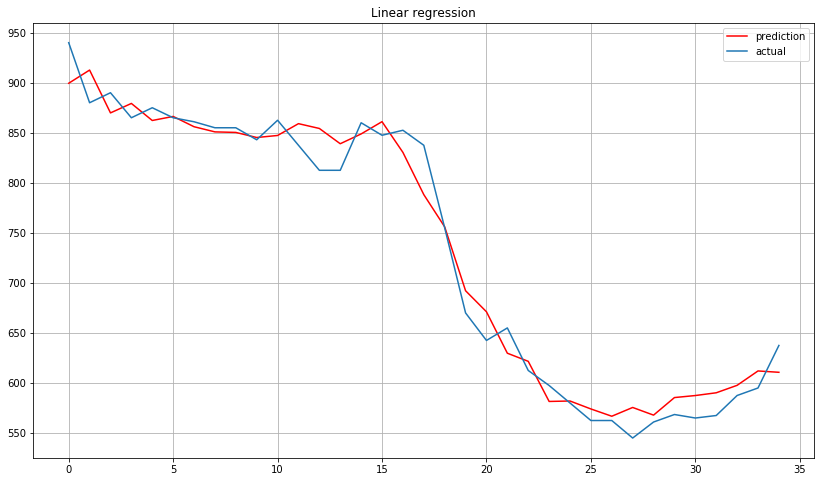

In [24]:
plt.figure(figsize=(14, 8))
plt.plot(y_pred_test, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [25]:
from sklearn.externals import joblib
joblib.dump(lr, 'linear_regression.pkl') 

#lr = joblib.load('linear_regression.pkl') 

['linear_regression.pkl']

In [32]:
# На 2 месяца  ( для этого срез на 12 месяцев)

df2month =df.copy()
df2month['Benzene Spot CIF ARA Current Month'] = df2month['Benzene Spot CIF ARA Current Month'].shift(12)
df2month = df2month[12:]


dff = df2month.drop(f, axis=1)

X_train, X_test, y_train, y_test = prepareData(dff, lag_start=1, lag_end=10, test_size=0.05)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('MAPE_train =', mean_absolute_percentage_error(y_train, y_pred_train))
print('MAPE_test =', mean_absolute_percentage_error(y_test, y_pred_test))
print('Parity =', mean_absolute_percentage_error(y_test, y_pred_test)/ mean_absolute_percentage_error(y_train, y_pred_train)  )

importance = pd.DataFrame(lr.coef_, X_train.columns).reset_index()
importance.columns = 'feat', 'score'
#importance.to_csv('importance.csv')

MAPE_train = 3.613380198306952
MAPE_test = 2.5509896186790026
Parity = 0.7059842802797968


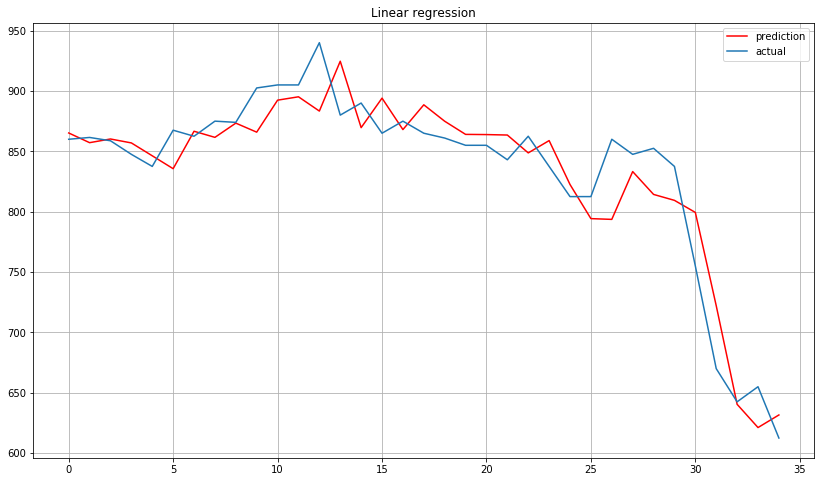

In [27]:
plt.figure(figsize=(14, 8))
plt.plot(y_pred_test, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [31]:
# на 3 месяца ( для этого срез на 18 месяцев)

df3month =df.copy()
df3month['Benzene Spot CIF ARA Current Month'] = df['Benzene Spot CIF ARA Current Month'].shift(18)
df3month = df3month[18:]


dff = df3month.drop(f, axis=1)
X_train, X_test, y_train, y_test = prepareData(dff, lag_start=1, lag_end=10, test_size=0.05)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('MAPE_train =', mean_absolute_percentage_error(y_train, y_pred_train))
print('MAPE_test =', mean_absolute_percentage_error(y_test, y_pred_test))
print('Parity =', mean_absolute_percentage_error(y_test, y_pred_test)/ mean_absolute_percentage_error(y_train, y_pred_train)  )

importance = pd.DataFrame(lr.coef_, X_train.columns).reset_index()
importance.columns = 'feat', 'score'
#importance.to_csv('importance.csv')

MAPE_train = 3.7827906472359487
MAPE_test = 2.2252905990414606
Parity = 0.5882669189391859


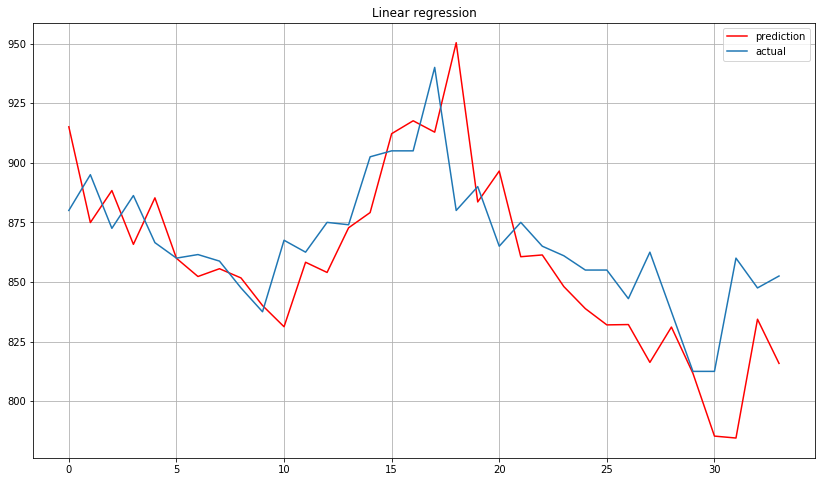

In [30]:
plt.figure(figsize=(14, 8))
plt.plot(y_pred_test, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

Были попробованы стандартные методы прогнозирования временного ряда, такие как ARIMA, EMA, Prophet, но с ними не получилось добиться приемлеого результата, тк ряд не сам себя обясняет а зависит от других параметров. Однако при построении регрессии использовались и лаги ряда, ema, ma. Полуилось добиться приемлемого результата на дистаниции прогнозирования = 6 недель ( на месяц вперед) Паритет между тестом и трейном снижается с 0.85 при прогозе на месяц до 0.55 (3 мес) ошибка так же возрастает.

Для дальнейших прознозов необходимо усреднить полученные значения. 

Так же для финальной модели была выбрана линейная регрессия, тк она умеет прогнозировать новые значения ( в отличии от деревьев), легко интерпретируема и можно будет легко использовать в работе.

### Так же нужно добавить в модель остановы заводов, что должно улучшить модель